<a href="https://colab.research.google.com/github/Lunaire86/notebooks/blob/main/python/loffsolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loffkoden

***«Klarer du å dekode loffen?»*** *«Det er mange gode grunner til å velge Experis Academy når du skal oppdatere IT-kunnskapene dine. [Her presenteres tre av de med loff](https://experisacademy.no/loffkoden).»*

### Initial thoughts
It's pretty clear that this has to be a binary representation of the message. Given how the pattern presents, visually speaking, an 8-bit grouping seems most likely. Groups of 4 might also be a contender, depending of whether it's a cipher or simply encoded.

#### Imports and setup

In [ ]:
%matplotlib inline

from os import path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# matplotlib setup
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

#### Pre-processing
This was done manually: 0 for light slice, 1 for dark. 

Since I like to use Pandas, the CSV format was used, and I started with the 4-bit grouping. It would've been fine to use only Numpy too, or even just Python, but Pandas lends itself to the visual exploration of data.

In [ ]:
df_raw = pd.read_csv(
    '/content/temp_data/loff_4d_binary.csv', 
    header=None, 
    index_col=None, 
    dtype=str
)
df_raw.head().style.hide_index()

0,1,2,3,4,5
0100,1100,1100,0011,1011,1000
0110,1110,0110,1110,0110,0101
0111,0100,0010,0000,0111,0101
0111,0100,0110,0100,0110,0001
0110,1110,0110,1110,0110,1001


I first wanted to check whether it could be as simple as converting each group of 4 bits to the decimal system, and mapping them to corresponding letters. This would mean using only 16 different letters, but it would be fairly simple to convey a message using only the 16 most commonly used letters, due to the letter frequency distribution in natural languages, i.e. Norwegian.

In [ ]:
# convert from base 2 to base 10, i.e. from binary to decimal
df = df_raw.copy().applymap(lambda x: np.str(np.int(x, 2)))
df.style.hide_index()

0,1,2,3,4,5
4,12,12,3,11,8
6,14,6,14,6,5
7,4,2,0,7,5
7,4,6,4,6,1
6,14,6,14,6,9
6,14,6,7,2,12
2,0,7,0,7,2
6,1,6,11,7,3
6,9,7,3,7,0
6,12,6,1,7,3


Let's have a look at the frequency distribution to see what it looks like. The Counter class works well for this purpose.

In [ ]:
fdist = Counter(df.to_numpy().ravel())
x_samples, y_freqs = zip(*sorted(fdist.items(), key=lambda x: x[1], reverse=True))

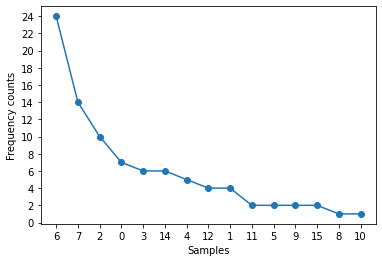

In [ ]:
plt.xticks(np.arange(len(x_samples)), x_samples)
plt.yticks(np.arange(0, np.max(y_freqs) + 1, step=2))
plt.xlabel('Samples')
plt.ylabel('Frequency counts')
plt.plot(y_freqs, '-o');

The frequency distribution of words tend to follow what is known as [Zipf's law](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4176592/), and though the same cannot be said for letters, we can generally expect the most frequent letter (in Norwegian) to occur nearly twice as often as the second most frequent, and a handful of letters with a frequency of >2%.

With a curve looking like this, it seems highly unlikely that the code is written using a classic Caesar (shift) cipher, but it *could* be a substitution cipher based on letter frequencies.

The list of character frequencies in Norwegian is generated from [NoWaC](http://tekstlab.uio.no/nowac/char_freqs_nowac-ansi.txt) (Norwegian Web as Corpus). In Norwegian, the letter **e** is the most frequent.

In [ ]:
top15 = 'ERTNSIALODGKMVP'
print(*top15, sep=' ')

E R T N S I A L O D G K M V P


We'll define a function that can be applied to a DataFrame. It takes a Series object and swaps occurences of encoded numbers with a given key.

In [ ]:
def crack(sequence, target,  key):
    """Replace the targeted number with the corresponding key."""
    return np.where(sequence != target, sequence, key)

In [ ]:
decoded = df.copy().transform(crack, 0, target='6', key='E')
decoded.head().style.hide_index()

0,1,2,3,4,5
4,12,12,3,11,8
E,14,E,14,E,5
7,4,2,0,7,5
7,4,E,4,E,1
E,14,E,14,E,9


Let's try some more!

In [ ]:
for i, letter in enumerate(top15):
    t = str(x_samples[i])
    decoded = decoded.transform(crack, 0, target=t, key=letter)
decoded.style.hide_index()

0,1,2,3,4,5
A,L,L,S,D,V
E,I,E,I,E,G
R,A,T,N,R,G
R,A,E,A,E,O
E,I,E,I,E,K
E,I,E,R,T,L
T,N,R,N,R,T
E,O,E,D,R,S
E,K,R,S,R,N
E,L,E,O,R,S


This doesn't look too promising.

Perhaps some of the letters on the letter frequency list have been swapped. Not too unlikely, given that different underlying training datasets can yield slightly different results.

In [ ]:
top15_alt = {
    1: 'ETRNSIALODGKMVP',  # RT -> TR
    2: 'ERNTSIALODGKMVP',  # TN -> NT
    3: 'ETNRSIALODGKMVP'}  # RTN -> TNR

In [ ]:
def freq_decoder(df, alphabet):
    """Decode and return a new DataFrame."""
    decoded = df.copy()
    for i, letter in enumerate(alphabet):
        t = str(x_samples[i])
        decoded = decoded.transform(crack, 0, target=t, key=letter)
    return decoded

Testing one by one, inspecting the tables as we go. If one suddenly clicks, there is no need to run the rest (i.e. further abstractions of this task isn't really called for).

In [ ]:
alt_one = freq_decoder(df, top15_alt[1])
alt_one[:8].style.hide_index()

0,1,2,3,4,5
A,L,L,S,D,V
E,I,E,I,E,G
T,A,R,N,T,G
T,A,E,A,E,O
E,I,E,I,E,K
E,I,E,T,R,L
R,N,T,N,T,R
E,O,E,D,T,S


In [ ]:
alt_two = freq_decoder(df, top15_alt[2])
alt_two[:8].style.hide_index()

0,1,2,3,4,5
A,L,L,S,D,V
E,I,E,I,E,G
R,A,N,T,R,G
R,A,E,A,E,O
E,I,E,I,E,K
E,I,E,R,N,L
N,T,R,T,R,N
E,O,E,D,R,S


Going nowhere, fast.

In [ ]:
alt_three = freq_decoder(df, top15_alt[3])
alt_three[:8].style.hide_index()

0,1,2,3,4,5
A,L,L,S,D,V
E,I,E,I,E,G
T,A,N,R,T,G
T,A,E,A,E,O
E,I,E,I,E,K
E,I,E,T,N,L
N,R,T,R,T,N
E,O,E,D,T,S


The curve made it look sort of interesting, but this is clearly not where it's at. The repeating patterns of certain letters, to me, also looks kind of sketchy.

Having scrapped the cipher theory, a more direct decoding approach makes sense. Let's see what the 4 bits look like converted to the hexadecimal system instead.

In [ ]:
hexdf = df.copy().applymap(lambda x: hex(int(x)))
hexdf[:2].style.hide_index()

0,1,2,3,4,5
0x4,0xc,0xc,0x3,0xb,0x8
0x6,0xe,0x6,0xe,0x6,0x5


Yeah. No. Chunks of 8 bits, please. This also means that we can ditch the DataFrame and work with Numpy instead. We won't have any use for the table view anymore,

In [ ]:
a = df_raw.to_numpy().ravel()
arr = np.array([a[i] + a[i + 1] for i in np.arange(0, a.size, 2)])

Let's look at the different representations, base 2 (binary), base 16 (hexadecimal) and base 10 (decimal), respectively:

In [ ]:
reprs = zip(
    arr[:3], 
    [hex(np.int(b, 2)) for b in arr[:3]],
    [np.int(b, 2) for b in arr[:3]]
)
print(*reprs, sep='\n')

('01001100', '0x4c', 76)
('11000011', '0xc3', 195)
('10111000', '0xb8', 184)


Using the built-in `bytes` method, we can convert integers (base 10) to Unicode characters:

In [ ]:
bytes([np.int(b, 2) for b in arr]).decode('utf-8')

'Lønnet utdanning, praksisplass og fast jobb.'

#### Let's wrap it up with a short, no nonsense solution:

In [ ]:
with open('/content/temp_data/loff.txt', 'r') as f:
    data = list(f.read().replace('\n', ''))

bytes(
    np.apply_along_axis(
        lambda x: np.int(''.join(x), 2),
        axis=1,
        arr=np.array(data).reshape(len(data) // 8, 8)
    ).tolist()
).decode('utf-8')

'Lønnet utdanning, praksisplass og fast jobb.'

With comments:

In [ ]:
# Construct an immutable array of bytes from
# an iterable yielding integers in range(256)
bytes(
    
    # apply a function to 1-D slices along the given axis
    np.apply_along_axis(
        
        # join as strings of 8 bits before converting to base 10
        lambda x: np.int(''.join(x), 2),
        
        # specify which axis our lil' lambda is applied along
        axis=1,
        
        # reshape data to groups of 8 bits, i.e. (360,) -> (45, 8)
        arr=np.array(data).reshape(len(data) // 8, 8)
        
    # pass to bytes() as a built-in list
    ).tolist()

# specify which encoding to use
).decode('utf-8')

'Lønnet utdanning, praksisplass og fast jobb.'